<a href="https://colab.research.google.com/github/AxelBadouel/machinelearningcourse/blob/main/Esercitazione_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLME: Datasets, dataloaders, augmentations




## 0 Table of contents
We're going to look at the PyTorch Workflow we've been learning and look at the data preparation steps.

![a PyTorch workflow with a computer vision focus](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-pytorch-computer-vision-workflow.png)

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. PyTorch Dataset** | How do we get and prepare the data to train and evaluate our models? To practice computer vision, we'll start with some images of different pieces of clothing from [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). |
| **1. Data visualization** | Once we have our dataset, we will try to visualize some data samples. Never forget to look at the data you have before starting to use it. |
| **2. PyTorch Dataloader** | With the dataset up and running, we will then see how we can get samples from it to train and test our models. We will use what a DataLoader |
| **3. Creating a custom Dataset** | "But I do not want to use a pre-loaded dataset, I wnat my custom dataset". Do not worry, we will look at how to create a custom dataset from the data. |
| **4. Loading data from a Google Drive** | Speaking of custom datasets, we will also look at how to import data stored in our Google Drive to a Colab.|
| **5. Data transformations** | An important part of the data preparation pipeline, is data pre-processing. We are going to look at how we can pre-process our data with several transformations. |

## 1 Useful resources and credits.
Official PyTorch tutorials:
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html

PyTorch Documentation
- https://pytorch.org/docs/stable/index.html

The material in this lecture draws from:
- exercises from E. Rodolà [classes](https://erodola.github.io/DLAI-s2-2024/)
- [Zero to Mastery Learn PyTorch for Deep Learning pt.3](https://www.learnpytorch.io/03_pytorch_computer_vision/)
- [Zero to Mastery Learn PyTorch for Deep Learning pt.4](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

## 2 How to run this notebook?
This notebook is *view only* and uses Google Colab to run. To **run this Colab notebook**, either:

- **Make a copy to your Google Drive so you can make local changes:** File > Save a copy in Drive...

- **Run in playground mode:** File > Open in playground mode
- **Download the Jupyter notebook, so you can run it on your computer configured with Jupyter:** File > Download .ipynb

## 3 Preliminaries

### 3.1 Important PyTorch libraries

Before we get started writing code, let's talk about some PyTorch computer vision libraries you should be aware of.

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. |
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  |
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iterable over a dataset (created with `torch.utils.data.Dataset`). |

> **Note:** The `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes aren't only for computer vision in PyTorch, they are capable of dealing with many different types of data.

### 3.2 Visualization tools
In this notebook we will use both **Matplotlib** and another plotting library, called **[Plotly](https://pyviz.org/overviews/index.html)**.
Effectively communicating your findings through plots and visualizations is an essential part of any scientific or engineering project.


Plotly is a modern library that makes interactive plots very easy to produce, and is very popular also outside of the DL community.
[Here](https://plot.ly/python/) you can find its documentation.

Now that we've covered some of the most important PyTorch computer vision libraries, let's import the relevant dependencies.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## 4 Loading a Dataset

In all learning problems, we have to deal with data. Data preparation is a fundamental step before building a model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

So let's make sure we prepare our data the best possible way!
In PyTorch (and other common frameworks) you can decouple the code that *manages* the data from the code that *uses* the data.

This produces simpler and more understandable code, and enables the possibility to re-use the same dataset with different models or the same model with different datasets.
In the following sections, we will have a glimpse into how to manage the data pipeline.

To handle data, PyTorch provides [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset). The PyTorch `Dataset` class that represents a data collection and stores the samples and their corresponding labels.
PyTorch domain libraries provide a number of pre-loaded datasets for tasks related to [computer vision](https://pytorch.org/vision/stable/datasets.html), [audio](https://pytorch.org/audio/stable/datasets.html), [text](https://pytorch.org/text/stable/datasets.html) and even [GeoAI](https://torchgeo.readthedocs.io/en/latest/api/datasets.html).

### 4.1 Load FashinMNIST
We're going to start with a computer vision dataset: [**FashionMNIST**](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST).

MNIST stands for Modified National Institute of Standards and Technology.

The [original MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services.

[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), made by Zalando Research, is a similar setup.

Except it contains grayscale images of 10 different kinds of clothing.

![example image of FashionMNIST](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-fashion-mnist-slide.png)
*`torchvision.datasets` contains a lot of example datasets you can use to practice writing computer vision code on. FashionMNIST is one of those datasets. And since it has 10 different image classes (different types of clothing), it's a multi-class classification problem.*


To download it, we provide the following parameters:
* `root: str` - which folder do you want to download the data to?
* `train: Bool` - do you want the training or test split?
* `download: Bool` - should the data be downloaded?
* `transform: torchvision.transforms` - what transformations would you like to do on the data? (**We will discuss transformations later**)
* `target_transform` - you can transform the targets (labels) if you like too (**We will discuss transformations later**).

Many other datasets in `torchvision` have these parameter options.

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.65MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's check what is our training data

In [ ]:
# What's train_data? What is one sample?
print(f"train_data is:\n{train_data}\n")
print(f"A single sample from train data is: {type(train_data[0])}")

# Let's check the first training sample
image, label = train_data[0]


train_data is:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

A single sample from train data is: <class 'tuple'>


We've got a big tensor of values (the image) leading to a single value for the target (the label).

Let's see the image shape.

In [ ]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor is `[1, 28, 28]` or more specifically:

```
[color_channels=1, height=28, width=28]
```

Having `color_channels=1` means the image is grayscale.

![example input and output shapes of the fashionMNIST problem](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-input-and-output-shapes.png)
*Various problems will have various input and output shapes. But the premise remains: encode data into numbers, build a model to find patterns in those numbers, convert those patterns into something meaningful.*

If `color_channels=3`, the image comes in pixel values for red, green and blue (this is also known as the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model)).

The order of our current tensor is often referred to as `CHW` (Color Channels, Height, Width).

There's debate on whether images should be represented as `CHW` (color channels first) or `HWC` (color channels last).

> **Note:** You'll also see `NCHW` and `NHWC` formats where `N` stands for *number of images*. For example if you have a `batch_size=32`, your tensor shape may be `[32, 1, 28, 28]`. We'll cover batch sizes later.

PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

However, PyTorch also explains that `NHWC` (channels last) performs better and is [considered best practice](https://pytorch.org/blog/tensor-memory-format-matters/#pytorch-best-practice).

Let's check out more shapes of our data.

In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

So we've got 60,000 training samples and 10,000 testing samples.

What classes are there?

We can find these via the `.classes` attribute.

In [ ]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Sweet! It looks like we're dealing with 10 different kinds of clothes.

Because we're working with 10 different classes, it means our problem is **multi-class classification**.

Let's get visual.

### 4.2 Visualizing the data
Checking the number of loaded samples, their shapes and labels is important. But, since we are dealing with images, we should also look at them, to understand the kind of data we are dealing with. Since the samples are images, it is straightforward to visualize them: we just need to show the images. For other datatypes, we may decide to use different kinds of plots.

Image shape: torch.Size([1, 28, 28])


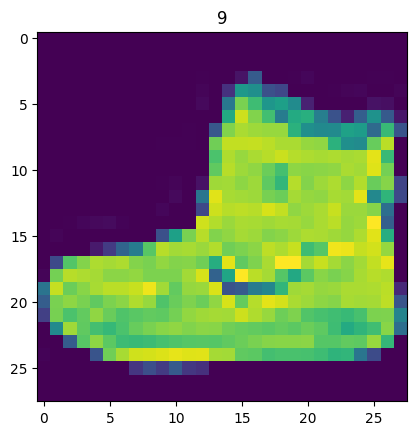

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

We can turn the image into grayscale using the cmap parameter of plt.imshow().

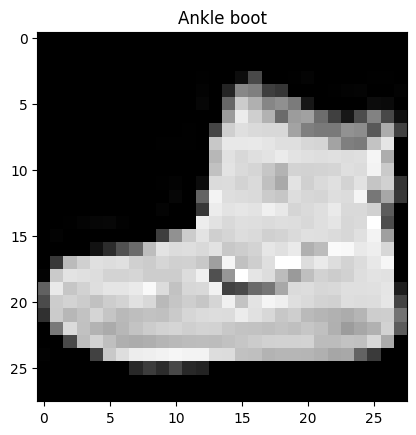

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

Beautiful, well as beautiful as a pixelated grayscale ankle boot can get.

Let's view a few more.

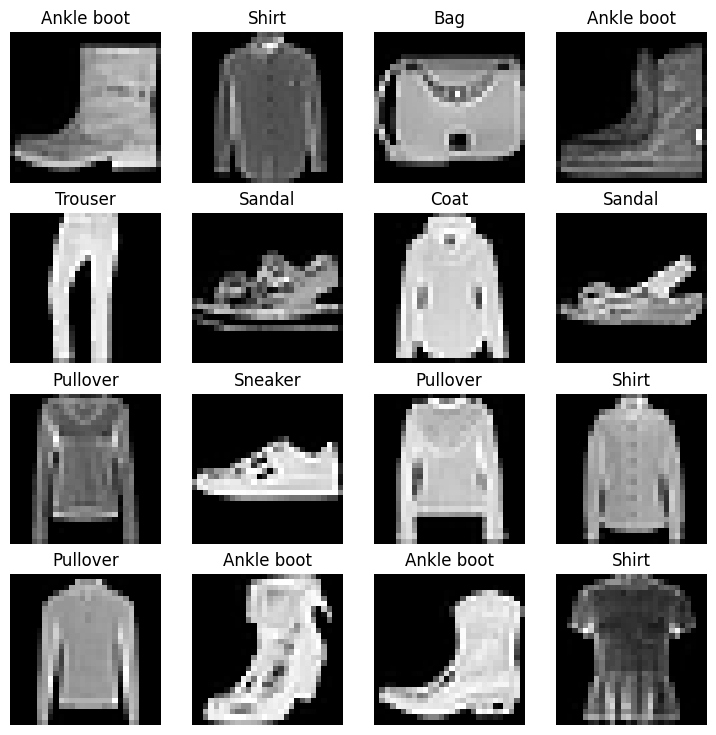

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Hmmm, this dataset doesn't look too aesthetic.

But the principles we're going to learn on how to build a model for it will be similar across a wide range of computer vision problems.

In essence, taking pixel values and building a model to find patterns in them to use on future pixel values.

Plus, even for this small dataset (yes, even 60,000 images in deep learning is considered quite small), could you write a program to classify each one of them?

You probably could.

## 5 📓 Exercise: load a dataset from PyTorch
Try to do the same thing, and load a different dataset from the ones [pre-loaded in PyTorch](https://pytorch.org/vision/stable/datasets.html). For example, try with the [**FGVCAircraft**](https://pytorch.org/vision/stable/generated/torchvision.datasets.FGVCAircraft.html#torchvision.datasets.FGVCAircraft) dataset.

Be mindful of the parameters this class expects. Check the documentation!
```
class torchvision.datasets.FGVCAircraft(root: Union[str, Path], split: str = 'trainval', annotation_level: str = 'variant', transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
```

In [3]:
train_data = datasets.FGVCAircraft(
    root="data",
    split="train",
    download=True,
    transform=ToTensor()
)

print(train_data)
img, label = train_data[100]
print(img.shape)
print(label)

100%|██████████| 2.75G/2.75G [00:30<00:00, 90.6MB/s]


Dataset FGVCAircraft
    Number of datapoints: 3334
    Root location: data
    StandardTransform
Transform: ToTensor()
torch.Size([3, 762, 1100])
3


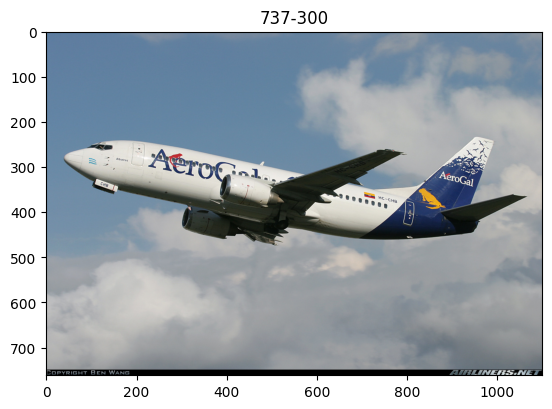

In [10]:
class_names = train_data.classes
plt.title(class_names[label])
plt.imshow(img.permute(1, 2, 0))

In [ ]:
# @title Solution
train_data = datasets.FGVCAircraft(
    root="data",
    split="train",
    download=True,
    transform=ToTensor()
)

print(train_data)
img, label = train_data[100]
print(img.shape)
print(label)
class_names = train_data.classes
plt.title(class_names[label])
# Note: permute() will change shape of image to suit matplotlib
# (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
plt.imshow(img.permute(1,2,0))

  9%|▉         | 262M/2.75G [01:12<11:30, 3.61MB/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-4cc7361ae5f3>", line 2, in <cell line: 0>
    train_data = datasets.FGVCAircraft(
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/datasets/fgvc_aircraft.py", line 60, in __init__
    self._download()
  File "/usr/local/lib/python3.11/dist-packages/torchvision/datasets/fgvc_aircraft.py", line 112, in _download
    download_and_extract_archive(self._URL, self.root)
  File "/usr/local/lib/python3.11/dist-packages/torchvision/datasets/utils.py", line 395, in download_and_extract_archive
    download_url(url, download_root, filename, md5)
  File "/usr/local/lib/python3.11/dist-packages/torchvision/datasets/utils.py", line 132, in download_url
    _urlretrieve(url, fpath)
  File "/usr/local/lib/python3.11/dist-packages/torc

TypeError: object of type 'NoneType' has no len()

## 6 Prepare a DataLoader

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.
The `DataLoader` does what you think it might do.
It helps load data into a model, both for training and for inference.
It turns a large `Dataset` into a Python iterable of smaller chunks.
These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

*Why do this?*

Because it's more computationally efficient.
In an ideal world you could do the forward pass and backward pass across all of your data at once.
But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

There are also motivations related to how the model are optimized using algorithms such as stochastic gradient descent


*What's a good batch size?*

It largely depends on the memory available on the GPU.
But since this is a value you can set (a **hyperparameter**) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

![an example of what a batched dataset looks like](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-batching-fashionmnist.png)
*Batching FashionMNIST with a batch size of 32 and shuffle turned on. A similar batching process will occur for other datasets but will differ depending on the batch size.*


PyTorch's `torch.utils.data.DataLoader` wraps an iterable around a `Dataset` object to enable easy access to the samples and gives us the following functionalities:
- Data batching
- Data shuffling
- Parallel data loading using multiprocessing workers. Meaning that while the GPU is performing some computation on a batch, in parallel you can load the next batch.

In other words, `DataLoader` is an iterable that abstracts this complexity for us in an easy API.

Let's create `DataLoader`'s for our training and test sets.

In [1]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython']


In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.8MB/s]


In [5]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7bc4a2ffe590>, <torch.utils.data.dataloader.DataLoader object at 0x7bc4a9b62b10>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

And we can see that the data remains unchanged by checking a single sample.

6
Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


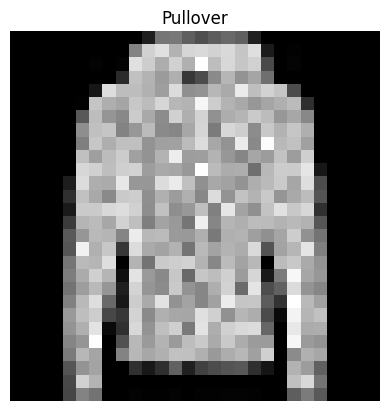

In [8]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
class_names = train_data.classes
print(random_idx)
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

There are other parameters that can be passed to a DataLoader constructore:
- `num_workers`: how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
- `pin_memory`: If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

For a full list of DataLoader's arguments check the [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [9]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm as tqdm   # just a progress bar
import time

BATCH_SIZE = 32
NUM_WORKERS = 8

train_dataloader = DataLoader(train_data,
                       batch_size=BATCH_SIZE,    # number of elements in each batch
                       shuffle=True,    # shuffle the dataset
                       num_workers=NUM_WORKERS,   # number of workers, i.e. batches to prefetch
                       pin_memory=True  # return memory-pinned tensors, see below for an explanation!
                       )

# 60000 iterations
for sample in tqdm(train_data):
  pass

# 60000/32 iterations
for batch in tqdm(train_dataloader):  # there is some overhead when using multiple workers!
  # time.sleep(0.1)
  pass

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

### 6.1 Notes
If the dataset does not return a dictionary or some other form of regular structure from the dataset, you must manually specify *how* to put the samples together to form a batch. This can be done with the `collate_fn` parameter of the `DataLoader`.

Please read these [docs](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) to understand the default behavior of `collate_fn` and how you can define custom `collate_fn` functions.

-----

The DataLoader is just an iterator, it can't be directly indexed!

In [10]:
try:
  train_dataloader[0]
except Exception as e:
  print('Error:', e)

Error: 'DataLoader' object is not subscriptable


## 7 Custom datasets

Although PyTorch offers a few pre-loaded datasets that can be used in just one line of code, most of the times we have to create a **custom dataset** using our own data.


A **custom dataset** is a collection of data relating to a specific problem you're working on.
In essence, a **custom dataset** can be comprised of almost anything.
For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>


We can create a custom dataset by extending (subclassing) the abstract `torch.utils.data.Dataset` class.



### 7.1 Creating a Dataset subclass

*What is [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)?*

It is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__`: The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).
- `__len__`: The `__len__` function returns the number of samples in our dataset.
- `__getitem__`: The `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image's location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

Let's see this in practice with a toy dataset:

In [3]:
from torch.utils.data import Dataset

class ToyDataset(Dataset): #our ToyDataset class inherits from the Dataset class

  def __init__(self, n_points: int = 20, noise: float = .1):
    super().__init__()  # In python 3 this is enough
    self.n_points = n_points
    # these two lines pre-load the entire dataset in memory
    self.x = torch.linspace(-1, 1, n_points)
    self.y = self.x ** 3 + noise * torch.randn(n_points)

  def __len__(self):
    return self.n_points

  def __getitem__(self, idx):
    return {
        'x': self.x[idx],
        'y': self.y[idx]
    }

toydataset = ToyDataset(40, noise=.1)
toydataset[5]

{'x': tensor(-0.7436), 'y': tensor(-0.2394)}

In this case the dataset is composed of simple pairs:

In [4]:
toydataset[2]

#Do you remember how to access the scalar number from a Tensor of rank 0?

{'x': tensor(-0.8974), 'y': tensor(-0.5378)}

In [13]:
toydataset[2]["x"].item()

-0.8974359035491943

Now, let's visualize the data. We are going to use Plotly, but we could also do it with Matplotlib

In [8]:
toydataset.x.numpy()

array([-1.        , -0.94871795, -0.8974359 , -0.84615386, -0.7948718 ,
       -0.74358976, -0.6923077 , -0.64102566, -0.5897436 , -0.5384615 ,
       -0.4871795 , -0.43589744, -0.38461536, -0.3333333 , -0.28205127,
       -0.23076922, -0.17948717, -0.12820512, -0.07692306, -0.02564101,
        0.02564101,  0.07692306,  0.12820512,  0.17948717,  0.23076922,
        0.28205127,  0.3333333 ,  0.38461536,  0.43589744,  0.4871795 ,
        0.5384615 ,  0.5897436 ,  0.64102566,  0.6923077 ,  0.74358976,
        0.7948718 ,  0.84615386,  0.8974359 ,  0.94871795,  1.        ],
      dtype=float32)

In [9]:
import plotly.express as px
fig = px.scatter(x=toydataset.x, y=toydataset.y)
fig.show()

> **NOTE**
>
> Small Python reminder. Every object that implements the `__getitem__` method follows the [iterator procotol](https://www.python.org/dev/peps/pep-0234/#python-api-specification). It means that you can **iterate** the dataset:




In [14]:
from tqdm.notebook import tqdm as tqdm   # just a progress bar
import time

for sample in tqdm(toydataset):  # wrap the iterable in tqdm and you're done
  time.sleep(0.1)
  pass

  0%|          | 0/40 [00:00<?, ?it/s]

In the `ToyDataset` the whole dataset is stored **in memory**, i.e. in attributes of the `ToyDataset` class.
This is the fastest and simplest way to implement a dataset, but it is **not always feasible**.
What if you must train a neural network on 500GB of images?
The whole dataset does not fit in memory!

For the same reason, using a single file to store the whole dataset does not scale with the dataset size.
*Obviously, this depends on the file format used, e.g. it is perfectly fine if we are dealing with `HDF5` files*

The `Dataset` abstraction is particularly useful when implementing *lazy loading* policies, that is, when you load each item **only when you need it**.
You can even apply some preprocessing on the fly, to each item.

One example of how it can be done:

```python
class LazyDataset(Dataset):

  def __init__(self, file_paths: Sequence[Path]):
    super().__init__()  
    self.file_paths = file_paths

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    sample_path = self.file_paths[idx]

    # -> Load sample_path in memory
    # -> Perform some lightweight preprocessing
    # -> Generate (sample_input, sample_output)

    return {
        'x': sample_input,
        'y': sample_output
    }

```


In [16]:
from torch.utils.data import Dataset
class LazyDataset(Dataset):

  def __init__(self, file_paths):
    super().__init__()
    self.file_paths = file_paths   # "drive/MyDrive/"

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, index):
    x = np.load(self.file_paths[index] + "x.npy")
    y = np.load(self.file_paths[index] + "y.npy")
    return x, y

**NOTE**

The dataset can return any type of object, you are *not* forced to return a dictionary of tensors:



In [17]:
from torch.utils.data import Dataset

class AnotherDataset(Dataset):
  def __init__(self):
    super().__init__()
    self.myitems = torch.arange(100)

  def __len__(self):
    return len(self.myitems)

  def __getitem__(self, idx):
    return f'Sample{idx}', self.myitems[idx], None, 3.5

dataset = AnotherDataset()
dataset[5]

('Sample5', tensor(5), None, 3.5)

In [ ]:
dataset[5][1].item()

5


However, it is often useful to return a dictionary of tensors.

⚠️ Do *not* return tensors that are stored on the GPU memory, as it [causes problems](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) with the multiprocessing behavior of the DataLoader. We'll see memory pinning as a preferred way, further below.

Returning a dictionary of tensors will:

- Make your code more readable
- Ease the batch creation process: you may use the `DataLoader` default `collate_fn` (we'll see this in a second)

### 7.2 Importing data from Google Drive
Cool, we created a custom dataset. But that example is not particularly useful, since we actually create the data within the Dataset object. Most commonly, we already have our data hosted somewhere.

Since we are working with Colab, it is quite convenient to import data from our Google Drive. However, if you were working on your computer the data may be located in some folder on your hard drive.

For this exercise, you can copy the data from this [folder](https://drive.google.com/drive/folders/1cIQg6GwSFRZRQ1PyFv6pRdeKxfBCr18F?usp=drive_link).
It is a very small (51 image) sample from the [IDDA dataset](https://idda-dataset.github.io/home/).
Once you have downloaded this data, put it in your Google Drive.


In Colab, you can mount your drive as follows
```
from google.colab import drive
drive.mount("/content/drive")
```

First, let's try to mount the drive

In [34]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [46]:
!ls /content/drive/MyDrive/Datasets/IDDA_examples\ \(1\)

'IDDA_examples (1)'


And let's see what is in our drive and if we can find our data.

In [48]:
print(f"1)")
!pwd #prints the path
print()

print(f"2)")
!ls #lists the folders and files at this level
print()

print("3)")
!ls drive/MyDrive/Old\ stuff #This is where the data is located
print()

print("4)")
!ls drive/MyDrive/Datasets/IDDA_examples\ \(1\)/RGB #Here are the images
print()

print("5)")
!ls drive/MyDrive/Datasets/IDDA_examples\ \(1\)/SemanticRGB # here are the labels

1)
/content

2)
drive  sample_data

3)
ls: cannot access 'drive/MyDrive/Old stuff': No such file or directory

4)
300_T01_CN_A.jpg  313_T01_CN_A.jpg  326_T01_CN_A.jpg  339_T01_CN_A.jpg
301_T01_CN_A.jpg  314_T01_CN_A.jpg  327_T01_CN_A.jpg  340_T01_CN_A.jpg
302_T01_CN_A.jpg  315_T01_CN_A.jpg  328_T01_CN_A.jpg  341_T01_CN_A.jpg
303_T01_CN_A.jpg  316_T01_CN_A.jpg  329_T01_CN_A.jpg  342_T01_CN_A.jpg
304_T01_CN_A.jpg  317_T01_CN_A.jpg  330_T01_CN_A.jpg  343_T01_CN_A.jpg
305_T01_CN_A.jpg  318_T01_CN_A.jpg  331_T01_CN_A.jpg  344_T01_CN_A.jpg
306_T01_CN_A.jpg  319_T01_CN_A.jpg  332_T01_CN_A.jpg  345_T01_CN_A.jpg
307_T01_CN_A.jpg  320_T01_CN_A.jpg  333_T01_CN_A.jpg  346_T01_CN_A.jpg
308_T01_CN_A.jpg  321_T01_CN_A.jpg  334_T01_CN_A.jpg  347_T01_CN_A.jpg
309_T01_CN_A.jpg  322_T01_CN_A.jpg  335_T01_CN_A.jpg  348_T01_CN_A.jpg
310_T01_CN_A.jpg  323_T01_CN_A.jpg  336_T01_CN_A.jpg  349_T01_CN_A.jpg
311_T01_CN_A.jpg  324_T01_CN_A.jpg  337_T01_CN_A.jpg  350_T01_CN_A.jpg
312_T01_CN_A.jpg  325_T01_CN_A.jpg

Now, let's read the paths of the images present in the folder and put them in a list.
We can do this in different ways. For example, we can use the [os](https://docs.python.org/3/library/os.html) package or the [pathlib](https://docs.python.org/3/library/pathlib.html) package

In [62]:
# @title Using pathlib and glob
from pathlib import Path

image_path = Path("drive/MyDrive/Datasets/IDDA_examples (1)/")
image_path_list = list(image_path.glob("RGB/*.jpg")) # [os.listdir(image_path+"RGB")]
print(image_path_list)


[PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/346_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/315_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/335_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/326_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/348_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/312_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/342_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/344_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/339_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/341_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/337_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/340_T01_CN_A.jpg'), PosixPath('drive/MyDrive/Datasets/IDDA_examples (1)/RGB/307_T01_CN_A.jpg'), PosixPath('

In [49]:
# @title Using os
import os

image_path = "drive/MyDrive/Datasets/IDDA_examples (1)"
for dirpath, dirnames, filenames in os.walk(image_path+"/RGB"):
  print(filenames)
print()

image_paths = os.listdir(image_path+"/RGB")
print(image_paths)

#Question: how can we exclude from the list the files that are not images?

['346_T01_CN_A.jpg', '315_T01_CN_A.jpg', '335_T01_CN_A.jpg', '326_T01_CN_A.jpg', '348_T01_CN_A.jpg', '312_T01_CN_A.jpg', '342_T01_CN_A.jpg', '344_T01_CN_A.jpg', '339_T01_CN_A.jpg', '341_T01_CN_A.jpg', '337_T01_CN_A.jpg', '340_T01_CN_A.jpg', '307_T01_CN_A.jpg', '338_T01_CN_A.jpg', '318_T01_CN_A.jpg', '349_T01_CN_A.jpg', '332_T01_CN_A.jpg', '317_T01_CN_A.jpg', '350_T01_CN_A.jpg', '325_T01_CN_A.jpg', '331_T01_CN_A.jpg', '329_T01_CN_A.jpg', '333_T01_CN_A.jpg', '321_T01_CN_A.jpg', '319_T01_CN_A.jpg', '334_T01_CN_A.jpg', '347_T01_CN_A.jpg', '343_T01_CN_A.jpg', '316_T01_CN_A.jpg', '328_T01_CN_A.jpg', '324_T01_CN_A.jpg', '306_T01_CN_A.jpg', '330_T01_CN_A.jpg', '309_T01_CN_A.jpg', '345_T01_CN_A.jpg', '313_T01_CN_A.jpg', '314_T01_CN_A.jpg', '304_T01_CN_A.jpg', '302_T01_CN_A.jpg', '310_T01_CN_A.jpg', '308_T01_CN_A.jpg', '320_T01_CN_A.jpg', '303_T01_CN_A.jpg', '301_T01_CN_A.jpg', '322_T01_CN_A.jpg', '300_T01_CN_A.jpg', '336_T01_CN_A.jpg', '323_T01_CN_A.jpg', '.DS_Store', '311_T01_CN_A.jpg', '327_T

In [52]:
# @title Soluzione
import os

image_path = "drive/MyDrive/Datasets/IDDA_examples (1)"
image_paths = [x for x in os.listdir(image_path+"/RGB") if x.endswith(".jpg")]
print(image_paths)

['346_T01_CN_A.jpg', '315_T01_CN_A.jpg', '335_T01_CN_A.jpg', '326_T01_CN_A.jpg', '348_T01_CN_A.jpg', '312_T01_CN_A.jpg', '342_T01_CN_A.jpg', '344_T01_CN_A.jpg', '339_T01_CN_A.jpg', '341_T01_CN_A.jpg', '337_T01_CN_A.jpg', '340_T01_CN_A.jpg', '307_T01_CN_A.jpg', '338_T01_CN_A.jpg', '318_T01_CN_A.jpg', '349_T01_CN_A.jpg', '332_T01_CN_A.jpg', '317_T01_CN_A.jpg', '350_T01_CN_A.jpg', '325_T01_CN_A.jpg', '331_T01_CN_A.jpg', '329_T01_CN_A.jpg', '333_T01_CN_A.jpg', '321_T01_CN_A.jpg', '319_T01_CN_A.jpg', '334_T01_CN_A.jpg', '347_T01_CN_A.jpg', '343_T01_CN_A.jpg', '316_T01_CN_A.jpg', '328_T01_CN_A.jpg', '324_T01_CN_A.jpg', '306_T01_CN_A.jpg', '330_T01_CN_A.jpg', '309_T01_CN_A.jpg', '345_T01_CN_A.jpg', '313_T01_CN_A.jpg', '314_T01_CN_A.jpg', '304_T01_CN_A.jpg', '302_T01_CN_A.jpg', '310_T01_CN_A.jpg', '308_T01_CN_A.jpg', '320_T01_CN_A.jpg', '303_T01_CN_A.jpg', '301_T01_CN_A.jpg', '322_T01_CN_A.jpg', '300_T01_CN_A.jpg', '336_T01_CN_A.jpg', '323_T01_CN_A.jpg', '311_T01_CN_A.jpg', '327_T01_CN_A.jpg',

Finally, let's create our custom dataset with the data that we have copied to our Drive. We will use the lazy approach, storing in the class not directly the data, but rather the paths to where it is stored.

### 7.3 Example: Custom Dataset from our Google Drive data

In [64]:
from PIL import Image

class IDDADataset(Dataset):

  def __init__(self, data_path):
    super().__init__()
    self.image_path = data_path+"/RGB/"
    self.label_path = data_path+"/SemanticRGB/"
    self.images_list = [x for x in os.listdir(self.image_path) if x.endswith(".jpg")]
    self.labels_list = [x for x in os.listdir(self.label_path) if x.endswith(".jpg")]

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    x_path = self.images_list[idx]
    y_path = self.labels_list[idx]

    # -> Load sample_path in memory
    x = np.array(Image.open(self.image_path+x_path))
    y = np.array(Image.open(self.label_path+y_path))

    # -> Generate (sample_input, sample_output)
    return {
        'x': x,
        'y': y
    }

idda_dataset = IDDADataset("drive/MyDrive/Datasets/IDDA_examples (1)")

Let's try and visualize a sample from our Custom Dataset

(1080, 1920, 3)
(1080, 1920, 3)


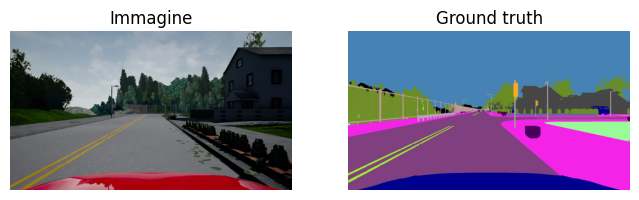

In [65]:
idda_dataset = IDDADataset("drive/MyDrive/Datasets/IDDA_examples (1)/")
N = 5
img = idda_dataset[N]["x"]
label = idda_dataset[N]["y"]
print(img.shape)
print(label.shape)


figure = plt.figure(figsize=(8, 8))

figure.add_subplot(1, 2, 1)
plt.title("Immagine")
plt.axis("off")
plt.imshow(img)

figure.add_subplot(1, 2, 2)
plt.title("Ground truth")
plt.axis("off")
plt.imshow(label)

plt.show()

### 7.4 DatasetFolder and ImageFolder
What we have seen in the previous section is a very general way for creating a custom dataset from our own data.
It turns out that for a multiclass classification task, PyTorch already provides some utilities to create a dataset giving as parameter the folders where the data is stored.

[`DatasetFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder)is a dataloader  that expects a certain directory structure can be customized by overriding the `find_classes()` method.

This is the kind of directory structure that it expects.
```
directory/
├── class_x
│   ├── xxx.ext
│   ├── xxy.ext
│   └── ...
│       └── xxz.ext
└── class_y
    ├── 123.ext
    ├── nsdf3.ext
    └── ...
    └── asd932_.ext
```
As you can see, the data is divided in folders, each folder corresponding to a class. For the custom dataset that we used, we could not use this method since it is not data formatted for a classification task.

The [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) operates similarly, but it is specific for images.
It expects the following directory structure

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png


## 8 📓 Exercise: Create a Custom Dataset

Try to put in practice the things we have see so far.
First things first we need some data.
And like any good cooking show, some data has already been prepared for us.

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.
And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).
Here you can [download the data](https://drive.google.com/drive/folders/1JaYA4aOWeCLhd-jYjVHgOiPcnSu0JR96?usp=sharing) and copy it to your Google Drive.

> **Note:** This dataset has been pre-formatted for a multi-class classification task and has the following directory structure
```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```
So you could try both to create a Custom Dataset as we have seen, or also try to use the ImageFolder method (which we have not tried).

What you should do:
1. load the data and mount your drive
2. create a dataset
3. check the dataset and visualize some data samples
4. create a dataloader


In [ ]:
# your code here

## 9 Data Transforms
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

For example, the FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.

*How can we do this?*
```
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
```
We can use transforms. Let's see an example and then comment it.

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

#### ToTensor
[`ToTensor()`](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html) is a PyTorch builtin transformation that converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales the image's pixel intensity values in the range [0., 1.]

#### Lambda Transforms
Lambda transforms apply any user-defined lambda function.

For example, we can define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls `scatter_` which assigns a value=1 on the index as given by the label `y`.

Now, let's check a sample from our dataset

In [ ]:
ds[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

Clearly, this works only when we load an existing dataset from PyTorch,
When we create a custom dataset, we should apply the transformation to the data ourselves.

When working with images, such as in the examples we have seen so far, we can rely on several existing transformations from the `torchvision.transforms` module.
`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes.

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [ ]:
from torchvision import transforms

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Now we've got a composition of transforms, let's write a function to try them out on various images.

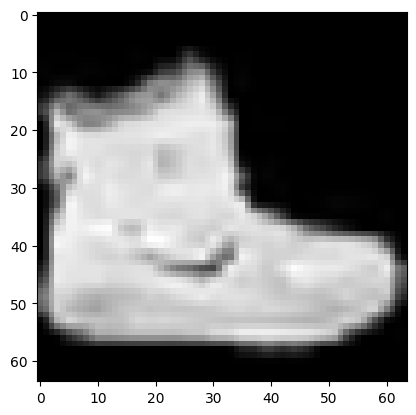

In [ ]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform,
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

img, label = ds[0]
plt.imshow(img.squeeze(), cmap="gray")

Now, let's try to use this same transform with our custom dataset

In [ ]:
class IDDADataset(Dataset):

  def __init__(self, data_path, data_transform, target_transform): #we pass the transform as argument
    super().__init__()
    self.image_path = data_path+"/RGB/"
    self.label_path = data_path+"/SemanticRGB/"
    self.images_list = [x for x in os.listdir(self.image_path) if x.endswith(".jpg")]
    self.labels_list = [x for x in os.listdir(self.label_path) if x.endswith(".jpg")]
    self.data_transform = data_transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    x_path = self.images_list[idx]
    y_path = self.labels_list[idx]

    # -> Load sample_path in memory
    x = self.data_transform(Image.open(self.image_path+x_path))
    y = self.target_transform(Image.open(self.label_path+y_path))

    # -> Generate (sample_input, sample_output)
    return {
        'x': x,
        'y': y
    }


idda_dataset = IDDADataset("drive/MyDrive/Datasets/IDDA_examples/", data_transform, transforms.ToTensor())
N = 5
img = idda_dataset[N]["x"]
label = idda_dataset[N]["y"]
print(img.shape)
print(label.shape)

figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1, 2, 1)
plt.title("Immagine")
plt.axis("off")
plt.imshow(torch.permute(img, (1,2,0)))
figure.add_subplot(1, 2, 2)
plt.title("Ground truth")
plt.axis("off")
plt.imshow(torch.permute(label, (1,2,0)))
plt.show()

## 10 🛑 Optional: Memory pinning

Pytorch tensors support [memory pinning](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/):

![](https://devblogs.nvidia.com/wp-content/uploads/2012/12/pinned-1024x541.jpg)


Pinned tensors enable:
- **Much faster copies** from CPU to GPU.
- **Aynchronous GPU copies**: *while* the tensor is being transferred, the code continues if it doesn't need that tensor! To enable this, just pass an additional **`non_blocking=True`** argument to a `to()` or a `cuda()` call.  (**gpu operations are [asynchronous](https://pytorch.org/docs/stable/notes/cuda.html#asynchronous-execution) by default**)

Given a tensor you can manually pin it:

In [ ]:
import torch
t = torch.rand(100)
t.is_pinned()

False

In [ ]:
# be sure to use a GPU runtime, otherwise there's nothing to pin for!

t = t.pin_memory()  # reassigning to t, because pin_memory() is not in-place

In [ ]:
t.is_pinned()

True

Passing `pin_memory=True` to a `DataLoader` will automatically put the fetched data tensors in pinned memory, enabling faster data transfer to CUDA-enabled GPUs.

`DataLoader` only knows how to pin the standard types returned by `Dataset`; this includes Tensor, Map and Sequence of Tensors. If you want to pin some custom type, read more [here](https://pytorch.org/docs/stable/data.html#memory-pinning) (tldr: define a `pin_memory()` method on your custom type(s)).

In [ ]:
batch['x'].is_pinned()

NameError: name 'batch' is not defined

### Troubleshooting bottlenecks
Make sure the data loading is **not a bottleneck** in your pipeline.
Your GPU must not **wait for data**.



#### How to check if your data loading is a bottleneck?

##### **Check resource usage**

Check the GPU (or CPU) usage, if it is ~$100\%$ it is being fully utilised. This is good!

Otherwise you may have a bottleneck somewhere, or your data operations may not be GPU friendly (e.g. small batches).


##### **Check data loading speed**

Iterate over the `Dataset` or `DataLoader` and check the data loading speed by counting the number of items that are loaded per second. Then compare this to how many items per second are processed by the rest of the pipeline.

If you can load more items than you can process in the training loop, it means you _don't_ have a bottleneck in your data loading. The GPU is not waiting for you, good job!

You can use the [tqdm](https://github.com/tqdm/tqdm) package to easily check the iteration speed of any iterable with a minimal overhead.

In [ ]:
# Checking the loading speed
from tqdm.notebook import tqdm as tqdm  # just a progress bar

toydataset = ToyDataset(20000)
toyloader = DataLoader(toydataset,
                       batch_size=8,    # number of elements in each batch
                       shuffle=True,    # shuffle the dataset
                       num_workers=4,   # number of workers, i.e. batches to prefetch
                       pin_memory=True  # return memory pinnded tensors
                       )
for batch in tqdm(toyloader):
  pass

# Example:
# tqdm reports 350.00it/s (iterations per second) for the loader.
# tqdm reports 280.12it/s for the training step given the data.
# -> data loading is NOT a bottleneck!
#
# This scenario means your computation time is the primary factor in how long
# each iteration takes, and the data loading process is efficient enough to keep
# up with the computational demands.

NameError: name 'ToyDataset' is not defined

#### How to fix a bottleneck in the data loading?

##### 1) **Use in-memory datasets**
If your dataset fits on memory, load the whole dataset in memory.

##### 2) **Tune DataLoader parameters**
Tune the `num_workers` and `batch_size` parameter of the `DataLoader`, paying attention that the batch size will have a direct impact on the training. A good default for `num_workers` is the number of cores in your CPU.

##### 3) **Do not preprocess on the fly**
If you need preprocessing for your files, save the preprocessed files to disk.

##### 4) **Speed up raw file loading**
If even just loading the files from disk is slow, consider changing the way in which the files are stored (e.g. another [format](https://www.h5py.org/) or a [database](https://github.com/google/leveldb)).

> **NOTE**
>
> You can read much more on the `torch.utils.data` package [here](https://pytorch.org/docs/stable/data.html).
>
> Moreover, keep in mind that the [`torchvision`](https://pytorch.org/vision/stable/index.html) package provides some common datasets and transforms. We'll use it next week!

## 11 📓 Optional Exercise

You want to create a neural network that is able to learn how to recover corrupted images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. That is, given as input a corrupted image, the model outputs a corresponding uncorrupted version.

You are free to choose the type of corruption to apply. Possible examples are: random noise, random black patches, random crop, random reflections, all the previous together.

1. Think about the data pipeline this model would require. What should the dataset return?
2. Create the `Dataset` and `DataLoader` to implement it.
3. Plot the images in a **batch** to ensure you are doing everything right.
4. Try to apply various transformations to the data

*hint*: you may use [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# ✏️ your code here